### Generic imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import time
import math
import random
import pandas as pd
import matplotlib.image as img
import matplotlib as mpl
import numpy as np

### Create DF from dataset using images in folder

In [3]:
DATASET_TRAIN_PATH = './DataSet/train/'
DATASET_TEST_PATH = './DataSet/test/'
DATASET_SAMPLE_PATH = './DataSet/sample/'

def create_df_from_images(ds_path):
    
    files = os.scandir(ds_path)
    train = pd.DataFrame(columns=['file_name','image','nbfinger','hand'])

    for idx,file in enumerate(files):
        if not file.name.startswith('.') and file.is_file() and file.name.endswith('.png'):
            fname = file.name
            complete_fname = os.path.join(ds_path,fname)
            root,ext = os.path.splitext(fname)
            image = img.imread(complete_fname)
#             image_resize = image.reshape(64,64)
            flat_image = image.flatten()
            train.loc[idx,'file_name'] = fname
            train.loc[idx,'image'] = flat_image
            train.loc[idx,'nbfinger'] = root[-2:-1]
            train.loc[idx,'hand'] = root[-1:]
            
    train['nbfinger'] = train['nbfinger'].astype('category')
    train['hand'] = train['hand'].astype('category')
    return train

t1 = time.time()
train = create_df_from_images(DATASET_TRAIN_PATH)
test = create_df_from_images(DATASET_TEST_PATH)
t2 = time.time()
print('dataset created in %.2f seconds' %(t2 - t1))

dataset created in 126.05 seconds


### Data exploration

Check repartition of images among categories - should be same for all

In [4]:
train['nbfinger'].value_counts()

5    3000
4    3000
3    3000
2    3000
1    3000
0    3000
Name: nbfinger, dtype: int64

In [5]:
train['hand'].value_counts()

R    9000
L    9000
Name: hand, dtype: int64

### Visualization

Display random image

file_name          fd186b81-cc51-4af3-a2ec-976c228491b5_0L.png
image        [0.18431373, 0.19215687, 0.20784314, 0.2117647...
nbfinger                                                     0
hand                                                         L
Name: 17799, dtype: object


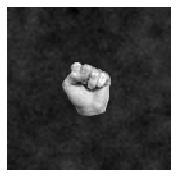

In [23]:
def plot_image(image):
    size = int(math.sqrt(len(image)))
    image_view = image.reshape(size,size)
    plt.imshow(image_view, cmap = mpl.cm.gray);
    plt.axis("off")

randidx = random.randint(0,len(train))
image = train.loc[randidx,'image']
print(train.loc[randidx,:])
plt.figure(figsize=(3,3))
plot_image(image)

Display batch images in a square matrix

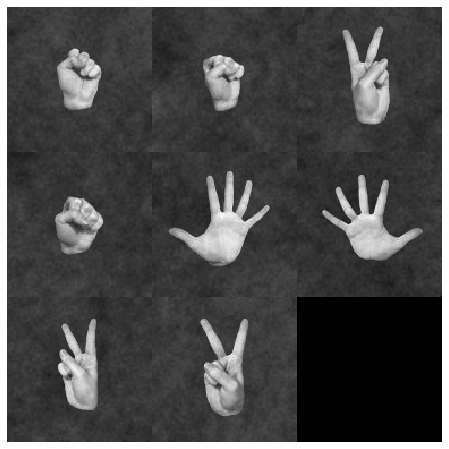

In [24]:
def plot_square_of_images(images):
    size=int(math.sqrt(len(images[0])))
    squaresize = math.ceil(math.sqrt(len(images)))
    im_row = []
    for row in range(squaresize):
        im_col=[]
        for col in range(squaresize):
            if col + squaresize * row < len(images):
                im = images[col + squaresize * row]
                im = im.reshape(size,size)
            else:
                im = np.zeros((size,size))
            im_col.append(im)
        rowofimages = np.concatenate(im_col,axis=1)
        im_row.append(rowofimages)
    squareofimages = np.concatenate(im_row,axis=0)
    flat_squareofimages = squareofimages.flatten()
    plot_image(flat_squareofimages)
    
images = train.loc[:7,'image']

plt.figure(figsize=(8,8))
plot_square_of_images(images)


### Classic classifiers

### Create train/test sets

In [8]:
xtrain = np.vstack(train['image'])
xtrain.shape

(18000, 16384)

In [36]:
from sklearn.preprocessing import LabelBinarizer

ytrain = train['hand']

encoder = LabelEncoder()
ytrain = encoder.fit_transform(ytrain)

ytrain.shape

(18000,)

In [37]:
xtest = np.vstack(test['image'])

In [38]:
ytest = train['hand']
ytest = encoder.fit_transform(ytest)

In [39]:
# no need to scale x
xtrain_s = xtrain
xtest_s = xtest

### PCA to speedup classifier training

In [ ]:
# very long on full training dataset 18000 instances.

from sklearn.decomposition import PCA
t1 = time.time()
pca = PCA(n_components=0.95)
# pca = PCA(n_components=0.95, svd_solver="randomized")
X_reduced = pca.fit_transform(xtrain_s)
t2 = time.time()
t2-t1

In [41]:
# check if faster
from sklearn.decomposition import IncrementalPCA
t1 = time.time()
n_batches = 50
inc_pca = IncrementalPCA(n_components=350)
for X_batch in np.array_split(xtrain_s, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(xtrain_s)
t2 = time.time()
t2-t1

78.86419796943665

In [42]:
print('dimension reduction from %d to %d after PCA preserving 95%% of variance' % (xtrain.shape[1],inc_pca.n_components_))

dimension reduction from 16384 to 350 after PCA preserving 95% of variance


Limit dataset for speed up tests

In [10]:
# trainsize = 2000
# testsize = 400

# xtrain_s = xtrain_s[:trainsize]
# xtest_s = xtrain_s[:testsize]
# ytrain = ytrain[:trainsize]
# ytest = ytest[:testsize]

### Train some classifiers to make first evaluation

In [43]:
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score

classifs = [
           SGDClassifier(random_state=37), 
           KNeighborsClassifier(),
           DecisionTreeClassifier(),
           SVC(),
           RandomForestClassifier(random_state=37),
           AdaBoostClassifier(random_state=37),
           GaussianNB(),
           ]

classif_names=[
               'SGD\t\t',
               'KNN\t\t', 
               'DecisionTree\t', 
               'SVC\t\t',
               'RandomForest\t',
               'AdaBoost\t',
               'Naive Bayes\t',]

# Apply different classifiers

t0 = time.time()
for name, clf in zip(classif_names, classifs):
    t1 = time.time()
    score = cross_val_score(clf, X_reduced, ytrain, cv=3, scoring="accuracy")
    t2 = time.time()    
    print("%.2f seconds - %s Score :" % ((t2-t1),name),score)

print('classifiers trained in %.2f seconds for %d instances' %((t2 - t0),len(xtrain_s)))

#     classifier = clf.fit(xtrain_s, ytrain)
#     ypred = classifier.predict(xtest_s)
#     score1 = classifier.score(xtest_s, ytest)*100
#     score2 = accuracy_score(ypred,ytest)*100
#     print("%s Score : %.2f %% %.2f" % (name, score1,score2))


0.38 seconds - SGD		 Score : [0.99916667 0.99833333 0.99966667]
45.54 seconds - KNN		 Score : [1. 1. 1.]
20.57 seconds - DecisionTree	 Score : [0.978      0.97133333 0.9735    ]
22.86 seconds - SVC		 Score : [1. 1. 1.]
45.95 seconds - RandomForest	 Score : [1. 1. 1.]
72.34 seconds - AdaBoost	 Score : [0.9775     0.97733333 0.977     ]
0.46 seconds - Naive Bayes	 Score : [0.9695     0.974      0.97366667]
classifiers trained in 208.10 seconds for 18000 instances


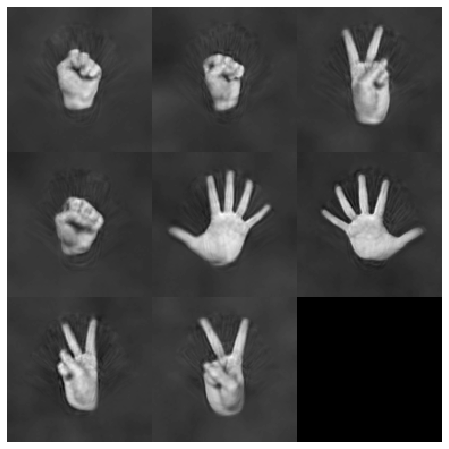

In [44]:
images = inc_pca.inverse_transform(X_reduced[:8])

plt.figure(figsize=(8,8))
plot_square_of_images(images)

In [45]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

clf = SGDClassifier(random_state=37)
score = cross_val_score(clf, X_reduced, ytrain, cv=5, scoring="accuracy")

score.min()

0.9977777777777778

### Precision vs Recall

In [47]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

ytrain_pred = cross_val_predict(clf, X_reduced, ytrain, cv=3)
confmatr = confusion_matrix(ytrain, ytrain_pred)

prec_score = precision_score(ytrain, ytrain_pred,average=None)
rec_score = recall_score(ytrain, ytrain_pred,average=None)
f1score = f1_score(ytrain, ytrain_pred,average=None)


In [48]:
y_scores = cross_val_predict(clf, X_reduced, ytrain, cv=3, method="decision_function")

In [51]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(ytrain, y_scores)

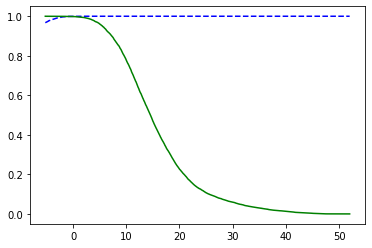

In [52]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

### ROC curve

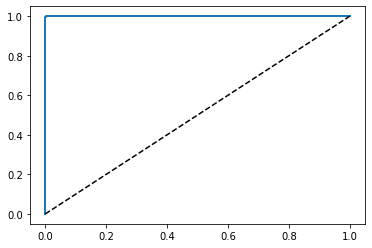

In [49]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(ytrain, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal

plot_roc_curve(fpr, tpr)
plt.show()


### Confusion Matrix

In [50]:
confmatr

array([[8996,    4],
       [  13, 8987]], dtype=int64)

In [ ]:
print(ytest[:15])
ypred = classifier.predict(xtest_s[:15])
ypred

